# Berlin Terraces - Decision Tree
**Technique:** Decision Trees<br>
**Guiding Documentation:** REVISE "Key References" links (Kotu/Deshpande, Airbnb Berlin inspiration)<br>
- **Prediction Goal: Where are the terraces in Berlin?** <br>
- **Process:** REVISE BELOW<br>
    1. **Prepare data:** data cleaning, feature engineering
    2. **Data exploration:** uni/multivariate exploration on numerical, categorical features
    3. **Pre-process data:** split, encode
    4. **Build model:** fit, plot tree, feature importance
    5. **Evaluate model:** confusion matrix
    6. **Optimize model:** tuning parameters, cross-validation<br>

**Idea:** *Recursive partitioning*<br>
**Math:** Shannon's Entropy (h), Information Gain (IG)<br>
**Dataset(s):** Inside Airbnb Berlin<br>
- (+) 
- (-) <br>

**Python:** Pandas, [Scikit-learn "DecisionTreeClassifier"](https://scikit-learn.org/stable/modules/tree.html)<br>
**Tuning Parameters (<):** decision math (IG, IG-ratio, Gini), pre/post-pruning STOP conditions<br>
**Advantages (+):** white box (explanatory), robust vs. missing/outlier/un-scaled data<br>
**Disadvantages (-):** **overfits** data if not pruning<br>
**Caveats (\*):**

Background about project: ADD

## Import packages, functions, and classes
Import libraries:
- Data Science: NumPy, Pandas<br>
- Decision tree model: **Scikit-learn**<br>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math #needed for floor, ceil in plotting setup functions

import re #regular expressions library

#scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

#Output mode switching: show all or only "last expression" (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#InteractiveShell.ast_node_interactivity = 'last_expr'

## 1. Prepare data
### Read from CSV
... add dataset details.

Feature and class column descriptions: ...<br>

In [2]:
csv_columns = ['name', 'description', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
              'property_type', 'room_type', 'amenities', 'price', 'number_of_reviews', 'review_scores_rating']
df_berlin = pd.read_csv('./data/berlin_listings_detailed.csv', usecols=csv_columns)
#df_berlin.info()

### Data Cleaning

- column names: neighbourhood, district (or borough)
- missing values:
    - description (566): "About the space" is optional so KEEP and fill with "No description"
    - name (32): also optional so KEEP/fill
    - review_scores_rating (4496): DROP (all number_of_reviews = 0, "some" number_of_reviews_ltm = 0)
- fix values: district, price
- data types:
    - change finite strings to **category**
    - change some floats to int (required missing/fix steps first!)
    
**Python:**
- fillna, dropna (column as subset!), string methods, data types, ...

In [3]:
# rename for clarity
df_berlin.rename(columns={
    'neighbourhood_cleansed': 'neighbourhood',
    'neighbourhood_group_cleansed': 'district',
    'review_scores_rating': 'rating'}, inplace=True)

# missing values (careful with inplace!)
df_berlin['description'].fillna('No description', inplace=True)
df_berlin['name'].fillna('No name', inplace=True)
df_berlin.dropna(axis=0, subset=['rating'], inplace=True)

# fix values
df_berlin['district'] = df_berlin['district'].str.replace(" ", "")
df_berlin['district'] = df_berlin['district'].replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_berlin['price'] = pd.to_numeric(df_berlin['price'].apply(
    lambda x: x.replace("$", "").replace(",","")))

# data types
columns_obj2cat = ['neighbourhood', 'district', 'property_type', 'room_type']
df_berlin[columns_obj2cat] = df_berlin[columns_obj2cat].astype('category')
columns_flt2int = ['price', 'rating']
df_berlin[columns_flt2int] = df_berlin[columns_flt2int].astype('int')

df_berlin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15362 entries, 0 to 19851
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               15362 non-null  object  
 1   description        15362 non-null  object  
 2   neighbourhood      15362 non-null  category
 3   district           15362 non-null  category
 4   latitude           15362 non-null  float64 
 5   longitude          15362 non-null  float64 
 6   property_type      15362 non-null  category
 7   room_type          15362 non-null  category
 8   amenities          15362 non-null  object  
 9   price              15362 non-null  int64   
 10  number_of_reviews  15362 non-null  int64   
 11  rating             15362 non-null  int64   
dtypes: category(4), float64(2), int64(3), object(3)
memory usage: 1.1+ MB


### Feature Engineering

We need to construct or "engineer" a class label for whether we think is a **terrace** in this listing.
- NO - 'amenities': look for "Patio or balcony" in JSON string of pre-defined amenities elements
    - discuss sampling: differences in meaning
- YES - 'description': look for "terrace" in host open-ended written dsecription ("About this space" on website)
    - discuss sampling
- ADD - 'name'
    - discuss discovery that (n) were missed by only looking at 'description'
- INCLUDE! - German word, misspellings of English/German
    - discuss sampling that (n) German descriptions (as expected) but also (n) misspellings

**Python:**
- "in" search operator returns boolean!
- but even better for open-ended (unstructured) text data: my old friend from Perl, **regular expressions!**
- Pandas `value_counts()` very useful for inline sanity checks of resulting data
- logical operators inside Pandas indexing

In [4]:
# Look for "Patio or balcony"
df_berlin['patio_balcony'] = df_berlin['amenities'].apply(
    lambda x: "Patio or balcony" in x)

# Look for "terrace", "terrasse", and misspellings
df_berlin['terrace_description'] = df_berlin['description'].apply(
    lambda x: bool(re.search("ter{1,2}a(c|s){1,2}e", x)))
df_berlin['terrace_name'] = df_berlin['name'].apply(
    lambda x: bool(re.search("ter{1,2}a(c|s){1,2}e", x)))
    
# cross-check results
#pd.DataFrame(df_berlin.value_counts()).pivot_table(index='terrace_description', columns='patio_balcony',
#                                                   aggfunc=np.sum)
pd.DataFrame(df_berlin.value_counts()).pivot_table(index='terrace_description', columns='terrace_name',
                                                   aggfunc=np.sum)
#df_berlin.loc[(~df_berlin['terrace_description'] & df_berlin['terrace_name'])].head()

# OR columns to create "terrace" class label
df_berlin['terrace'] = df_berlin['terrace_description'] | df_berlin['terrace_name']

0      
terrace_name         False True 
terrace_description             
False                14653    28
True                   563   118

### Class Balance
Discuss initial class balance of terrace True vs False

In [5]:
df_berlin['terrace'].value_counts()
df_berlin['terrace'].value_counts(normalize=True)

False    14653
True       709
Name: terrace, dtype: int64

False    0.953847
True     0.046153
Name: terrace, dtype: float64

## 2. Data exploration
### Univariate - numerical
Quick check on two numerical features: price and rating.

In [6]:
# by default, for only numerical features 
df_berlin.describe().round(3)

,latitude,longitude,price,number_of_reviews,rating
count,15362.000,15362.000,15362.000,15362.000,15362.000
mean,52.510,13.405,67.316,28.302,94.531
std,0.032,0.061,83.786,52.944,8.293
min,52.340,13.098,8.000,1.000,20.000
25%,52.490,13.372,35.000,3.000,93.000
50%,52.510,13.415,50.000,8.000,97.000
75%,52.533,13.439,79.000,27.000,100.000
max,52.656,13.758,4000.000,618.000,100.000


### Price - initial check for outliers

With a very large "max" value, price has obvious outlers.<br>
Let's visualize with a histogram and accompanying box plot.

**Notes:**
- Boxplot fence/outlier boundaries are 5/95% quantiles

**Python:**
- Plotting helper functions

In [7]:
def histogram_bins(d_min=0, d_max=10, d_binw=0.5):
    """Setup histogram binning based on (d)ata inputs using NumPy to create list of bin edges
    
    Parameters
    ----------
    d_min : first bin left edge (default=0)
    d_max : last bin left edge (default=10)
    d_binw : bin width
    
    Returns
    -------
    histogram_bins : ndarray
        Bin edges for `bins` input of Pandas/Matplotlib histogram methods
        Note: last bin is [d_max, d_max+d_binw]"""
        
    return np.round_(np.arange(d_min, d_max+(2*d_binw), d_binw), decimals=1) #2*d_binw so max value gets own bin

def plot_setup(
        wspace=0.1, hspace=0.3,
        xsetup=True,
        xd_min=0, xd_max=10, x_grid=1, xlabel='default x-axis label',
        x_padding=0,
        ysetup=False,
        yd_min=0, yd_max=10, y_grid=1, ylabel='default y-axis label',
        y_padding=0):
    """Matplotlib plotting customization
    
    Parameters
    ----------
    wspace : width space (horizontal) between subplots (default=0.1)
    hspace : height space (vertical) between subplots (default=0.3)
    xsetup : setups x-axis for all subplots (default=True)
    ysetup : setups y-axis for all subplots (default=False)
    x_padding : add to axis limits on both sides for outliers, Gaussian tails (default=0)
    y_padding : add to axis limits on both sides for outliers, Gaussian tails (default=0)
    ...
    
    Returns
    -------
    No return value"""
    
    #Spacing between subplots
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    
    #Setup x-axis label, limits, and grid spacing
    if xsetup:  
        x_min = math.floor(xd_min)-x_padding
        x_max = math.ceil(xd_max)+x_padding
        plt.setp(axes, xlabel=xlabel, xlim=[x_min, x_max], xticks=np.arange(x_min, x_max, x_grid))
    
    #Setup y-axis label, limits, and grid spacing
    if ysetup:
        y_min = math.floor(yd_min)-y_padding
        y_max = math.ceil(yd_max)+y_padding
        plt.setp(axes, ylabel=ylabel, ylim=[y_min, y_max], yticks=np.arange(y_min, y_max, y_grid))

Text(100, 1500, 'Mean = 67.316\nMedian = 50.0\nSD = 83.786\n')

<AxesSubplot:title={'center':'price Historgram'}, xlabel='Euros per night', ylabel='Frequency'>

<AxesSubplot:xlabel='Euros per night'>

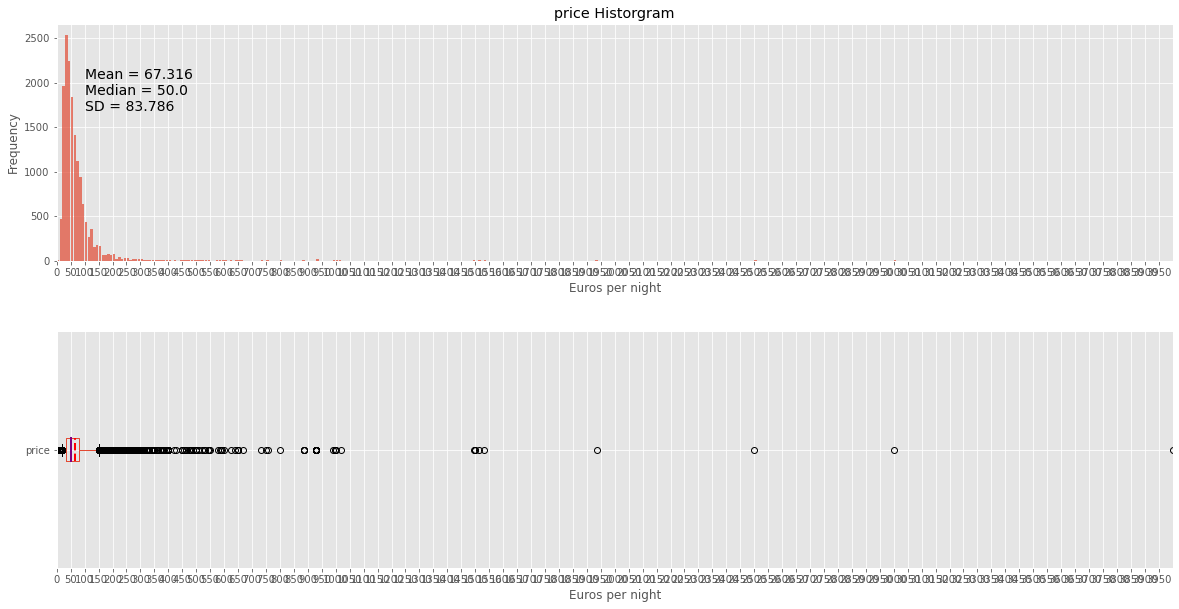

In [8]:
column = 'price' #variable to plot
text_xy = (100, 1500) #Matplotlib text() uses data coordinates, need to adjust for each attribute's histogram

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
plot_setup(xd_min=0, xd_max=d_tuple[1], x_grid=50, xlabel='Euros per night')

#Histogram binning setup based on (d)ata, bin width = data granularity of 10 Euros
d_bins = histogram_bins(d_min=0, d_max=d_tuple[1], d_binw=10)

axes[0].text(text_xy[0], text_xy[1],
             f'Mean = {df_berlin[column].mean().round(3)}\n'
             f'Median = {df_berlin[column].median().round(3)}\n'
             f'SD = {df_berlin[column].std().round(3)}\n', fontsize=14)

df_berlin[column].plot.hist(ax=axes[0], bins=d_bins,
                            rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                            title=f'{column} Historgram')

df_berlin[column].plot.box(ax=axes[1], vert=False, #horizontal!
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.1)) #skinnier like book

In [9]:
df_berlin['price'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

1.00    4000.0
0.95     150.0
0.75      79.0
0.50      50.0
0.25      35.0
0.05      20.0
0.00       8.0
Name: price, dtype: float64

**Observations**
- mean larger than median (positive-skew) due to high-priced "luxury" outliers
- very high outliers, so remove in next section

### Price after removing outliers

For better analysis (a more representative mean), and better graphing, we remove prices from 500 EUR and above.<br>
Replot histogram and boxplot.

In [10]:
#berlin_airbnb = berlin_airbnb[berlin_airbnb.price < 1000] # To get around the long tail outliers
df_berlin = df_berlin[df_berlin['price'] < 500]
df_berlin['terrace'].value_counts()
df_berlin['terrace'].value_counts(normalize=True)

False    14599
True       696
Name: terrace, dtype: int64

False    0.954495
True     0.045505
Name: terrace, dtype: float64

Text(100, 1500, 'Mean = 63.421\nMedian = 50.0\nSD = 46.151\n')

<AxesSubplot:title={'center':'price Historgram'}, xlabel='Euros per night', ylabel='Frequency'>

<AxesSubplot:xlabel='Euros per night'>

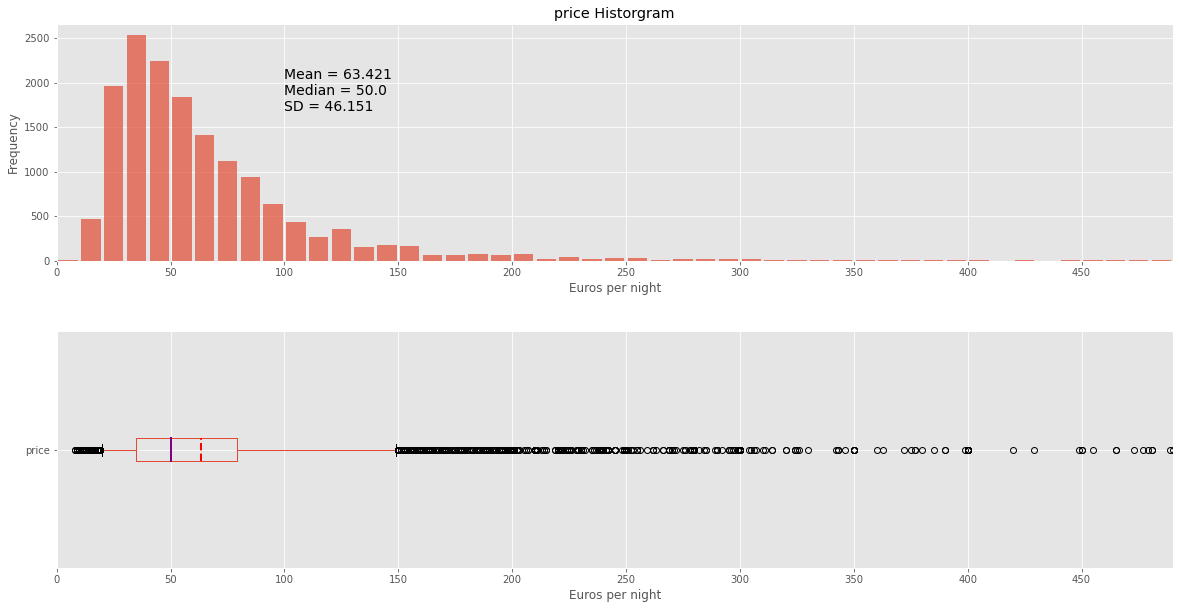

In [11]:
column = 'price' #variable to plot
text_xy = (100, 1500) #Matplotlib text() uses data coordinates, need to adjust for each attribute's histogram

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
plot_setup(xd_min=0, xd_max=d_tuple[1], x_grid=50, xlabel='Euros per night')

#Histogram binning setup based on (d)ata, bin width = data granularity of 10 Euros
d_bins = histogram_bins(d_min=0, d_max=d_tuple[1], d_binw=10)

axes[0].text(text_xy[0], text_xy[1],
             f'Mean = {df_berlin[column].mean().round(3)}\n'
             f'Median = {df_berlin[column].median().round(3)}\n'
             f'SD = {df_berlin[column].std().round(3)}\n', fontsize=14)

df_berlin[column].plot.hist(ax=axes[0], bins=d_bins,
                            rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                            title=f'{column} Historgram')

df_berlin[column].plot.box(ax=axes[1], vert=False, #horizontal!
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.1)) #skinnier like book

In [12]:
df_berlin['price'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

1.00    490.0
0.95    149.0
0.75     79.0
0.50     50.0
0.25     35.0
0.05     20.0
0.00      8.0
Name: price, dtype: float64

**Observations**<br>
As expected after removing outliers from 500 EUR and above:
- mean moves closer to median from 67 to 63 EUR
- median doesn't change at 50 EUR
- SD almost halved from 84 to 46 EUR

### Price by-terrace
Let's see how the price distributions differ by whether it has a terrace or not?<br>
Run same plots stratified/grouped by 'terrace'.<br>
For histogram, need to **normalize** because of unbalanced classes, and for comparison to Kernel Density Estimate (KDE)
- "make the historgram bars comparable (as probabiliy % bars) to a 'smoothened' curve estimate called KDE"

In [13]:
df_berlin.groupby('terrace')['price'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
terrace,,,,,,,,
False,14599.0,61.852,44.338,8.0,35.0,50.0,75.0,490.0
True,696.0,96.338,66.641,9.0,50.0,80.0,120.0,479.0


**Observations:**<br>
Just from describe(), we can already see a shift to pricier places when a "terrace" is present:
- the mean shifts up from 62 to 96 EUR
- **the median also shifts up from 50 to 80 EUR** so the mean shift is not just due to a few expensive outliers
- there is a 9 EUR terrace available!

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: price, dtype: object

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: price, dtype: object

<AxesSubplot:title={'center':'price'}, xlabel='terrace'>

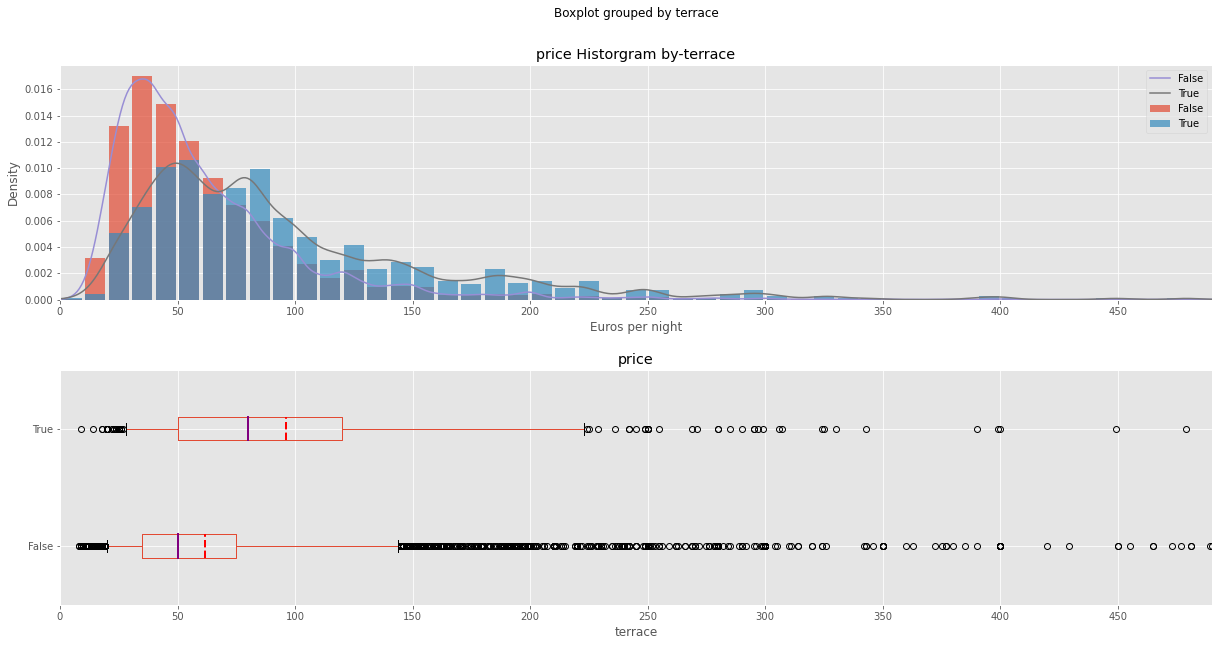

In [14]:
column = 'price' #variable to plot
group = 'terrace' #variable to group-"by"

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
#d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
d_tuple = (0, df_berlin[column].max().max()) # hardcode min to 0
plot_setup(xd_min=d_tuple[0], xd_max=d_tuple[1], x_grid=50, xlabel='Euros per night')

#Histogram binning setup based on (d)ata, bin width = data granularity of 10 Euros
d_bins = histogram_bins(d_min=d_tuple[0], d_max=d_tuple[1], d_binw=10)

df_berlin.groupby(group)[column].plot.hist(ax=axes[0], density=True,
                                                   bins=d_bins,
                                                   rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                                                   title=f'{column} Historgram by-terrace',
                                                   legend=True)
df_berlin.groupby(group)[column].plot.kde(ax=axes[0],
                                                  bw_method=0.1, legend=True) #bw_method='scott' (default), 'silverman', scalar
    
df_berlin.boxplot(by=group, column=column, ax=axes[1], vert=False,
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.2)) #skinnier like book

In [15]:
df_berlin.groupby('terrace')['price'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

terrace      
False    1.00    490.00
         0.95    144.00
         0.75     75.00
         0.50     50.00
         0.25     35.00
         0.05     20.00
         0.00      8.00
True     1.00    479.00
         0.95    223.25
         0.75    120.00
         0.50     80.00
         0.25     50.00
         0.05     27.75
         0.00      9.00
Name: price, dtype: float64

**Observations:**
- terrace True (vs False) historgram/KDE indeed shifts to higher prices and more spread out (higher SD)
- terrace True looks bi-modal at around 50 and 80 EUR
- differences are prominent in box plots as well

### Review score rating - dataset
Similar analysis as price for rating:
- keep all because of bounded range from 20-100

Text(85, 2000, 'Mean = 94.53\nMedian = 97.0\nSD = 8.279\n')

<AxesSubplot:title={'center':'rating Historgram'}, xlabel='Review score rating out of 100', ylabel='Frequency'>

<AxesSubplot:xlabel='Review score rating out of 100'>

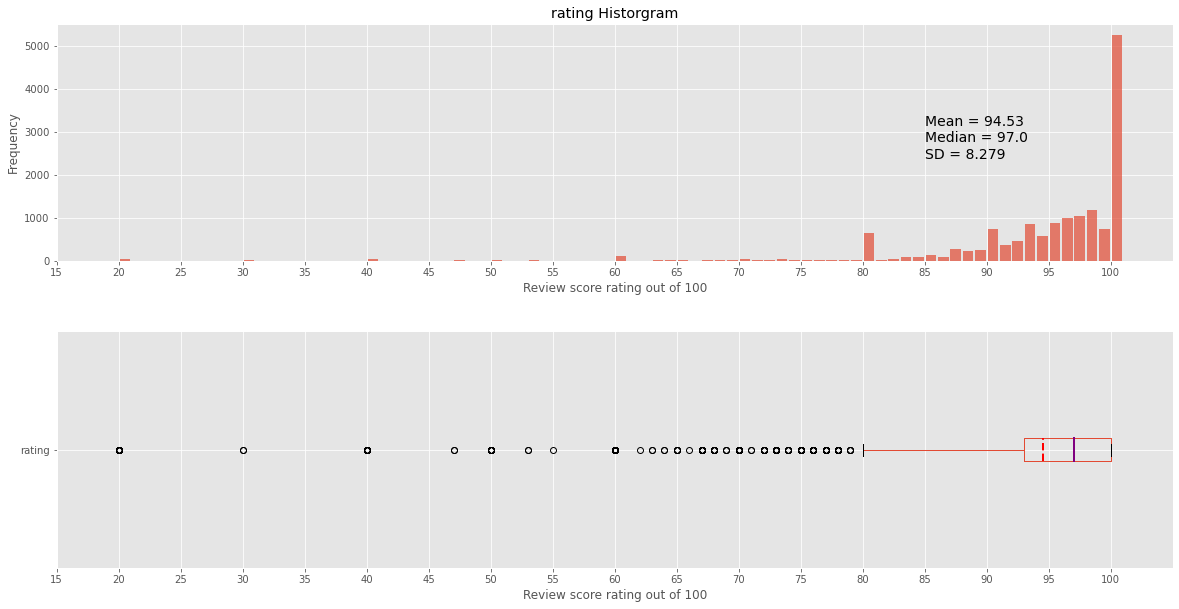

In [16]:
column = 'rating' #variable to plot
text_xy = (85, 2000) #Matplotlib text() uses data coordinates, need to adjust for each attribute's histogram

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
plot_setup(xd_min=d_tuple[0], xd_max=d_tuple[1], x_grid=5, x_padding=5, xlabel='Review score rating out of 100')

#Histogram binning setup based on (d)ata, bin width = data granularity of 1 (many scores bunched up in 90s)
d_bins = histogram_bins(d_min=d_tuple[0], d_max=d_tuple[1], d_binw=1)

axes[0].text(text_xy[0], text_xy[1],
             f'Mean = {df_berlin[column].mean().round(3)}\n'
             f'Median = {df_berlin[column].median().round(3)}\n'
             f'SD = {df_berlin[column].std().round(3)}\n', fontsize=14)

df_berlin[column].plot.hist(ax=axes[0], bins=d_bins,
                            rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                            title=f'{column} Historgram')

df_berlin[column].plot.box(ax=axes[1], vert=False, #horizontal!
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.1)) #skinnier like book

In [17]:
df_berlin['rating'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

1.00    100.0
0.95    100.0
0.75    100.0
0.50     97.0
0.25     93.0
0.05     80.0
0.00     20.0
Name: rating, dtype: float64

**Observations:**
- Very negative-skewed with the mean less than the median due to "bad rating" outliers (less than 80)
- IQR box (25-75/100%) is bunched up in the high ratings: 90s to the maximum of 100 (93-100)
- a ratings mode of 100! (something to explore?)

### Review score ratings - by-terrace
Similar analysis as price by-terrace for rating by-terrace:

In [18]:
df_berlin.groupby('terrace')['rating'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
terrace,,,,,,,,
False,14599.0,94.456,8.386,20.0,92.0,97.0,100.0,100.0
True,696.0,96.085,5.367,60.0,95.0,98.0,100.0,100.0


**Observations:**<br>
From describe(), we can see:
- the mean and median do shift up slightly for terrace True
- interestingly, the ratings spread is tighter (smaller SD) for terraces, different than price spread
    - but low rating outliers also affect SD so take with a grain of salt
    - "while terrace prices have a wider range, the satisfication with them are more consistenly high"

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: rating, dtype: object

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: rating, dtype: object

<AxesSubplot:title={'center':'rating'}, xlabel='terrace'>

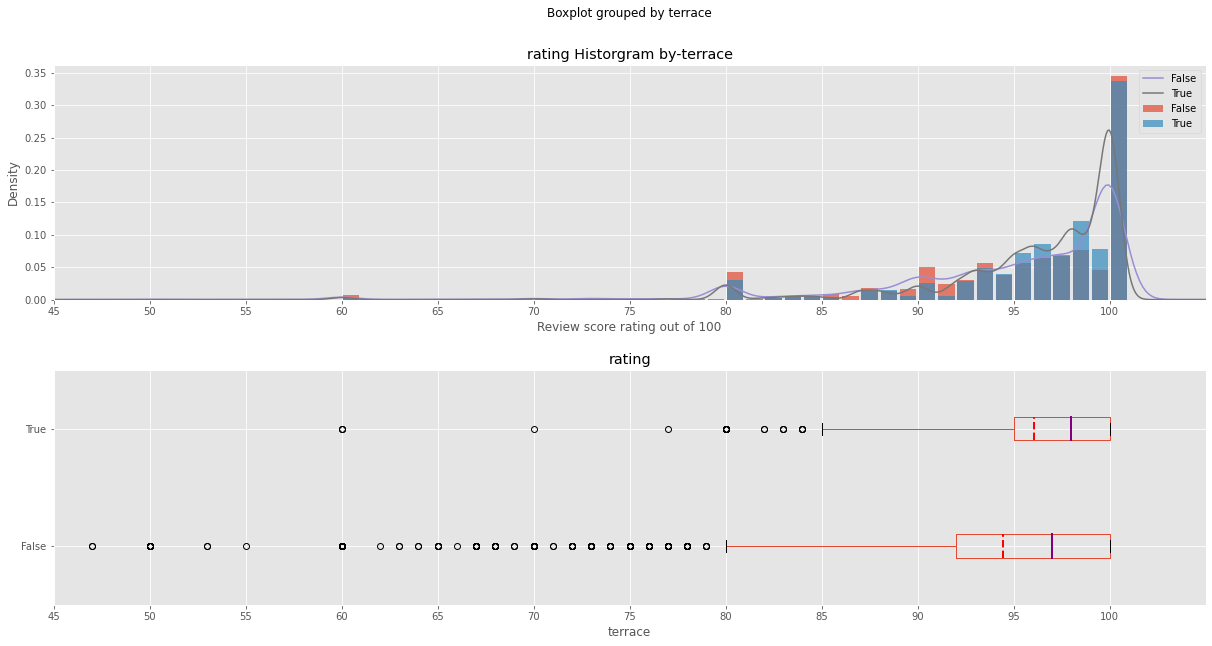

In [19]:
column = 'rating' #variable to plot
group = 'terrace' #variable to group-"by"

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (50, df_berlin[column].max().max()) # hardcode min to 50
plot_setup(xd_min=d_tuple[0], xd_max=d_tuple[1], x_grid=5, x_padding=5, xlabel='Review score rating out of 100')

#Histogram binning setup based on (d)ata, bin width = data granularity of 1 rating score
d_bins = histogram_bins(d_min=d_tuple[0], d_max=d_tuple[1], d_binw=1)

df_berlin.groupby(group)[column].plot.hist(ax=axes[0], density=True,
                                                   bins=d_bins,
                                                   rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                                                   title=f'{column} Historgram by-terrace',
                                                   legend=True)
df_berlin.groupby(group)[column].plot.kde(ax=axes[0],
                                                  bw_method=0.1, legend=True) #bw_method='scott' (default), 'silverman', scalar
    
df_berlin.boxplot(by=group, column=column, ax=axes[1], vert=False,
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.2)) #skinnier like book

**Observations:**<br>
- difficult to see much difference in histogram/KDE plots
- box plots show better here slightly higher ratings for terraces

### Multivariate - numeric
Compare price and rating to answer: ss there any relationship between price and rating?

**Python - Pandas:**
- surprisingly, `plot.scatter` argument for color to re-specify DF

[Text(0.5, 0, 'price'), Text(0, 0.5, 'rating')]

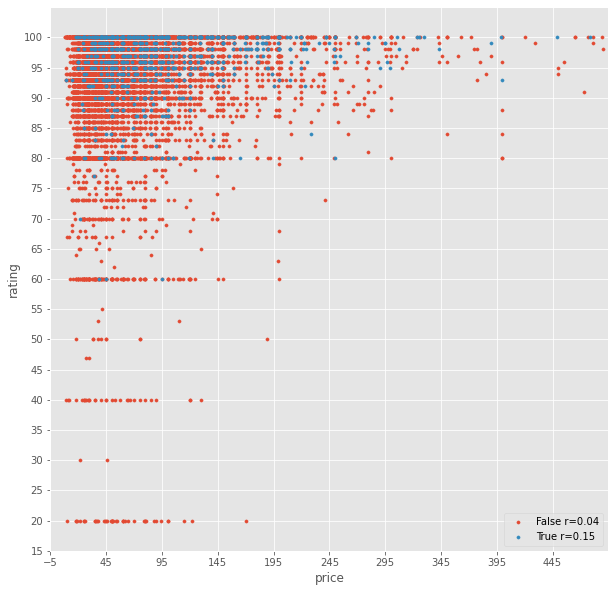

In [20]:
xcol = 'price'
ycol = 'rating'
group = 'terrace'

#create subplots: setup 1x1 Axes in one Figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

#setup plot grids based on (d)ata #hard code min/max to zoom
plot_setup(xd_min=0, xd_max=df_berlin[xcol].max(), x_grid=50, x_padding=5,
           ysetup=True, yd_min=df_berlin[ycol].min(), yd_max=df_berlin[ycol].max(), y_grid=5, y_padding=5)

#df_berlin.plot.scatter(ax=ax, x=xcol, y=ycol, c=df_berlin['terrace'], colormap='summer')

corr_vars = dict(pearson='r', spearman='rho', kendall='tau')
corr_method = 'pearson' #'pearson', 'spearman', 'kendall'

# use Matplotlib native "scatter" for fuller control
#Scatter plot by-class (groupby)
df_berlin_grouped = df_berlin.groupby(group) #for each group: tuple of (name, subsetted object)
for group_name, group in df_berlin_grouped:
    label = f'{group_name} {corr_vars[corr_method]}={group.corr(method=corr_method).at[xcol,ycol].round(2)}'
    axes.scatter(x=group[xcol], y=group[ycol], label=label, s=10)
            
axes.set(xlabel=xcol, ylabel=ycol)
axes.legend()

**Observations**
- discrete ratings lines at 20, 40, 60, 80
- terrace True has tighter "bunch-up" at high (90+) ratings
- not indicated in correlation measures, but visually, there is a logarithmic-looking "curved boundary" that suggests:
    - higher prices are more exclusively high ratings (more effort by hosts?)
    - lower prices also have high ratings but includes more low ratings (more mixed quality)

### Experiment: price vs. ratings "range"
Let's plot that and see what we get.

<AxesSubplot:xlabel='price'>

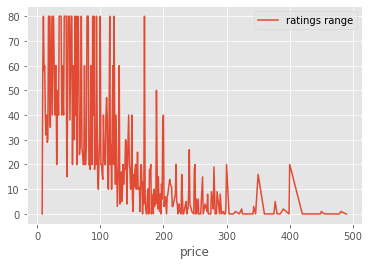

In [21]:
pd.DataFrame(df_berlin.groupby('price').apply(lambda x: x['rating'].max() - x['rating'].min()),
             columns=['ratings range']).plot()

**Observations:**
- Yes! Noisy (would be good to bin prices) but we do see a trend of higher prices > smaller ratings range

### Univariate - categorical
Quick look at our categorical variables

In [22]:
df_berlin.describe(include='category')

,neighbourhood,district,property_type,room_type
count,15295,15295,15295,15295
unique,136,12,63,4
top,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,Entire apartment,Entire home/apt
freq,874,3514,7404,8499


### Districts

,listings_norm,terrace_norm
Charlottenburg-Wilmersdorf,0.079830,0.071839
Friedrichshain-Kreuzberg,0.229748,0.225575
Lichtenberg,0.028571,0.033046
Marzahn-Hellersdorf,0.006080,0.004310
Mitte,0.213992,0.225575
Neukölln,0.141092,0.089080
Pankow,0.163387,0.206897
Reinickendorf,0.013403,0.015805
Spandau,0.007192,0.011494
Steglitz-Zehlendorf,0.019287,0.027299


<AxesSubplot:title={'center':'Listings and Terraces (normalized to 1) per-District'}>

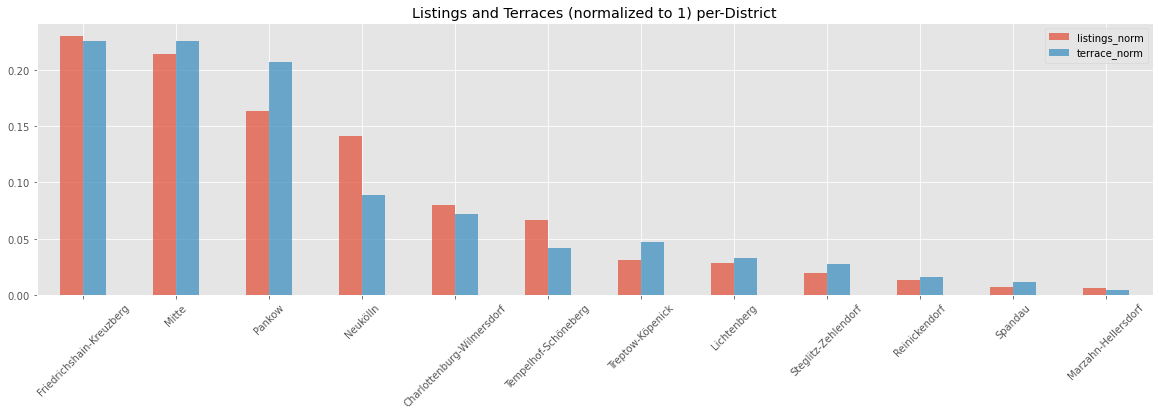

In [23]:
xcol = 'district'
group = 'terrace'

# setup DataFrame for normalized per-district data
df_berlin_district_norm = pd.DataFrame(
    {'listings_norm': df_berlin[xcol].value_counts()/df_berlin[xcol].count(),
     'terrace_norm' : df_berlin.loc[df_berlin[group], xcol].value_counts()/df_berlin[group].sum()})
df_berlin_district_norm

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
df_berlin_district_norm.sort_values(by='listings_norm', ascending=False).plot.bar(ax=axes, rot=45, alpha=0.7,
                                 title='Listings and Terraces (normalized to 1) per-District')

**Observations:**
- Fairly similar normalized listings vs terrace % per-district
- setting absolute number of listings aside:
    - Pankow a better bet to find a terrace
    - Neukölln not a good of a bet to find a terrace

### Room type

,listings_norm,terrace_norm
Entire home/apt,0.555672,0.731322
Hotel room,0.007192,0.008621
Private room,0.423537,0.257184
Shared room,0.013599,0.002874


<AxesSubplot:title={'center':'Listings and Terraces (normalized to 1) per-Room Type'}>

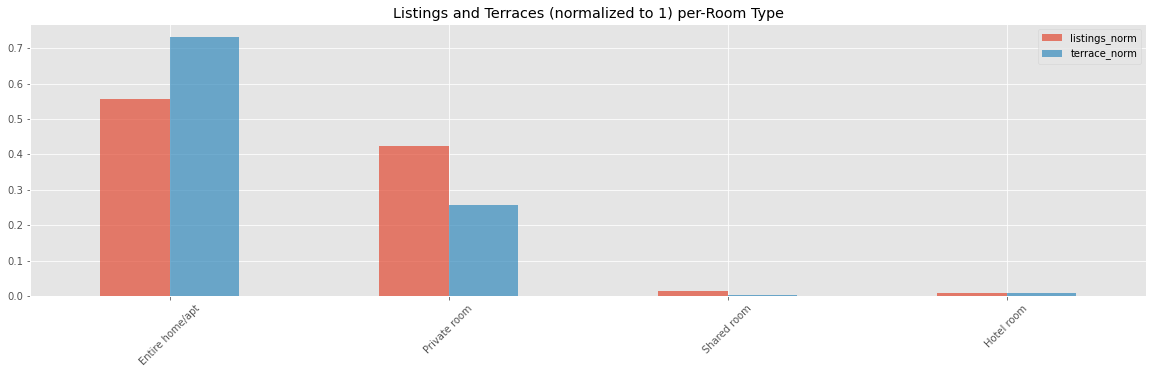

In [24]:
xcol = 'room_type'
group = 'terrace'

# setup DataFrame for normalized per-district data
df_berlin_room_type_norm = pd.DataFrame(
    {'listings_norm': df_berlin[xcol].value_counts()/df_berlin[xcol].count(),
     'terrace_norm' : df_berlin.loc[df_berlin[group], xcol].value_counts()/df_berlin[group].sum()})
df_berlin_room_type_norm

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
df_berlin_room_type_norm.sort_values(by='listings_norm', ascending=False).plot.bar(ax=axes, rot=45, alpha=0.7,
                                 title='Listings and Terraces (normalized to 1) per-Room Type')

**Observations:**
- Stronger data than district is room type!
    - better choices in "Entire home/apt" than for "Private room" which makes functional sense
    - shared and hotel rooms have very small numbers but "Shared room" is looking like the worse bet for finding a terrace

### Multivariate - categorical

**Python - Pandas**
- discovered `crosstab` which seems to be `pivot_table` with the ability to normalize by rows or columns

In [25]:
# use crosstab to normalize (i.e. % by row) for each district
pd.crosstab(df_berlin.loc[df_berlin[group]]['district'], df_berlin.loc[df_berlin[group]]['room_type'])
pd.crosstab(df_berlin.loc[df_berlin[group]]['district'], df_berlin.loc[df_berlin[group]]['room_type'],
            normalize='index')

room_type,Entire home/apt,Hotel room,Private room,Shared room
district,,,,
Charlottenburg-Wilmersdorf,36,0,14,0
Friedrichshain-Kreuzberg,111,0,45,1
Lichtenberg,17,0,6,0
Marzahn-Hellersdorf,2,0,1,0
Mitte,115,6,36,0
Neukölln,37,0,24,1
Pankow,118,0,26,0
Reinickendorf,7,0,4,0
Spandau,6,0,2,0


room_type,Entire home/apt,Hotel room,Private room,Shared room
district,,,,
Charlottenburg-Wilmersdorf,0.720000,0.000000,0.280000,0.000000
Friedrichshain-Kreuzberg,0.707006,0.000000,0.286624,0.006369
Lichtenberg,0.739130,0.000000,0.260870,0.000000
Marzahn-Hellersdorf,0.666667,0.000000,0.333333,0.000000
Mitte,0.732484,0.038217,0.229299,0.000000
Neukölln,0.596774,0.000000,0.387097,0.016129
Pankow,0.819444,0.000000,0.180556,0.000000
Reinickendorf,0.636364,0.000000,0.363636,0.000000
Spandau,0.750000,0.000000,0.250000,0.000000


**Observations:**
- more Entire room/apt's with terraces than other room types holds up by-district
- Pankow sticks out again for having the largest % of its terraces in "Entire home/apt" at 82%

### Data exploration - observations summary
Best potential features for predicting terraces:
- higher prices
- more consistent high ratings
- district: Pankow >> Neukölln
- room type: Entire room/apt >> Private room >> Shared room

Feature relationships:
- Price vs ratings **range** (negative correlation)

## 3. Pre-process data

Note: split data before encoding to follow rule.

### Split data

In [26]:
# separate X (features) and y (class) columns
X_cols = ['district', 'room_type', 'price', 'rating']
df_berlin_X = df_berlin[X_cols]
df_berlin_y = df_berlin['terrace']

# split the dataset into train and test sets (returns DataFrame for X!)
df_X_train, df_X_test, s_y_train, s_y_test = train_test_split(df_berlin_X, df_berlin_y, test_size=0.33, random_state=1)

### Encode categorical data

**Python:**
- need Pandas `reset_value` to re-align DataFrame indexes

In [27]:
# split X numerical, categorical columns
X_num = df_X_train.select_dtypes('number').columns
X_cat = df_X_train.select_dtypes('category').columns
y_label = s_y_train.name

# reset indexing so re-combining num and cat columns works
df_X_train.reset_index(inplace=True, drop=True)
s_y_train.reset_index(inplace=True, drop=True)
df_X_test.reset_index(inplace=True, drop=True)
s_y_test.reset_index(inplace=True, drop=True)

# one-hot encode categorical attributes only
onehotenc = OneHotEncoder(sparse=False)
df_X_train_catenc = pd.DataFrame(
    onehotenc.fit_transform(df_X_train[X_cat]),
    columns=onehotenc.get_feature_names(X_cat))
df_X_test_catenc = pd.DataFrame(
    onehotenc.transform(df_X_test[X_cat]),
    columns=onehotenc.get_feature_names(X_cat))

#combine back with numerical attributes
df_X_train_enc = pd.concat([df_X_train_catenc, df_X_train[X_num]], axis=1)
df_X_test_enc = pd.concat([df_X_test_catenc, df_X_test[X_num]], axis=1)

#also need to encode the Y "label" (class) data
labelenc = LabelEncoder()
s_y_train_enc = pd.Series(labelenc.fit_transform(s_y_train), name=y_label)
s_y_test_enc = pd.Series(labelenc.transform(s_y_test), name=y_label)

## 4. Build model
Instantiate and fit `DecisionTreeClassifier`.

**Python:**
- need NumPy `astype(str)` to input **boolean** class values as printable strings

11

268

,feature_importances_,permutation_importances_train,permutation_importances_train_norm
price,5.776822e-01,-0.012901,1.669895
rating,2.116373e-01,0.016096,-2.083368
district_Friedrichshain-Kreuzberg,3.004305e-02,0.001688,-0.218526
district_Treptow-Köpenick,2.530617e-02,0.003126,-0.404632
room_type_Entire home/apt,2.476623e-02,-0.017260,2.234105
district_Tempelhof-Schöneberg,2.064906e-02,0.005228,-0.676632
district_Mitte,2.023490e-02,0.001002,-0.129684
district_Neukölln,1.604763e-02,0.001330,-0.172211
district_Pankow,1.414945e-02,0.004775,-0.618105
room_type_Private room,1.054852e-02,-0.016480,2.133053


[Text(3180.7166115863142, 5209.5, 'price <= 76.5\ngini = 0.5\nsamples = 10247\nvalue = [5123.5, 5123.5]\nclass = True'),
 Text(1638.5283825816484, 4756.5, 'price <= 40.5\ngini = 0.466\nsamples = 7599\nvalue = [3871.159, 2278.346]\nclass = False'),
 Text(797.8402021772939, 4303.5, 'price <= 30.5\ngini = 0.38\nsamples = 3773\nvalue = [1943.956, 666.833]\nclass = False'),
 Text(336.81765163297047, 3850.5, 'district_Treptow-Köpenick <= 0.5\ngini = 0.305\nsamples = 2044\nvalue = [1058.626, 244.505]\nclass = False'),
 Text(170.30715396578537, 3397.5, 'rating <= 91.5\ngini = 0.273\nsamples = 1975\nvalue = [1024.595, 200.05]\nclass = False'),
 Text(69.42457231726283, 2944.5, 'district_Tempelhof-Schöneberg <= 0.5\ngini = 0.076\nsamples = 520\nvalue = [271.725, 11.114]\nclass = False'),
 Text(52.06842923794712, 2491.5, 'gini = -0.0\nsamples = 488\nvalue = [255.494, 0.0]\nclass = False'),
 Text(86.78071539657853, 2491.5, 'rating <= 74.0\ngini = 0.482\nsamples = 32\nvalue = [16.23, 11.114]\nclass 

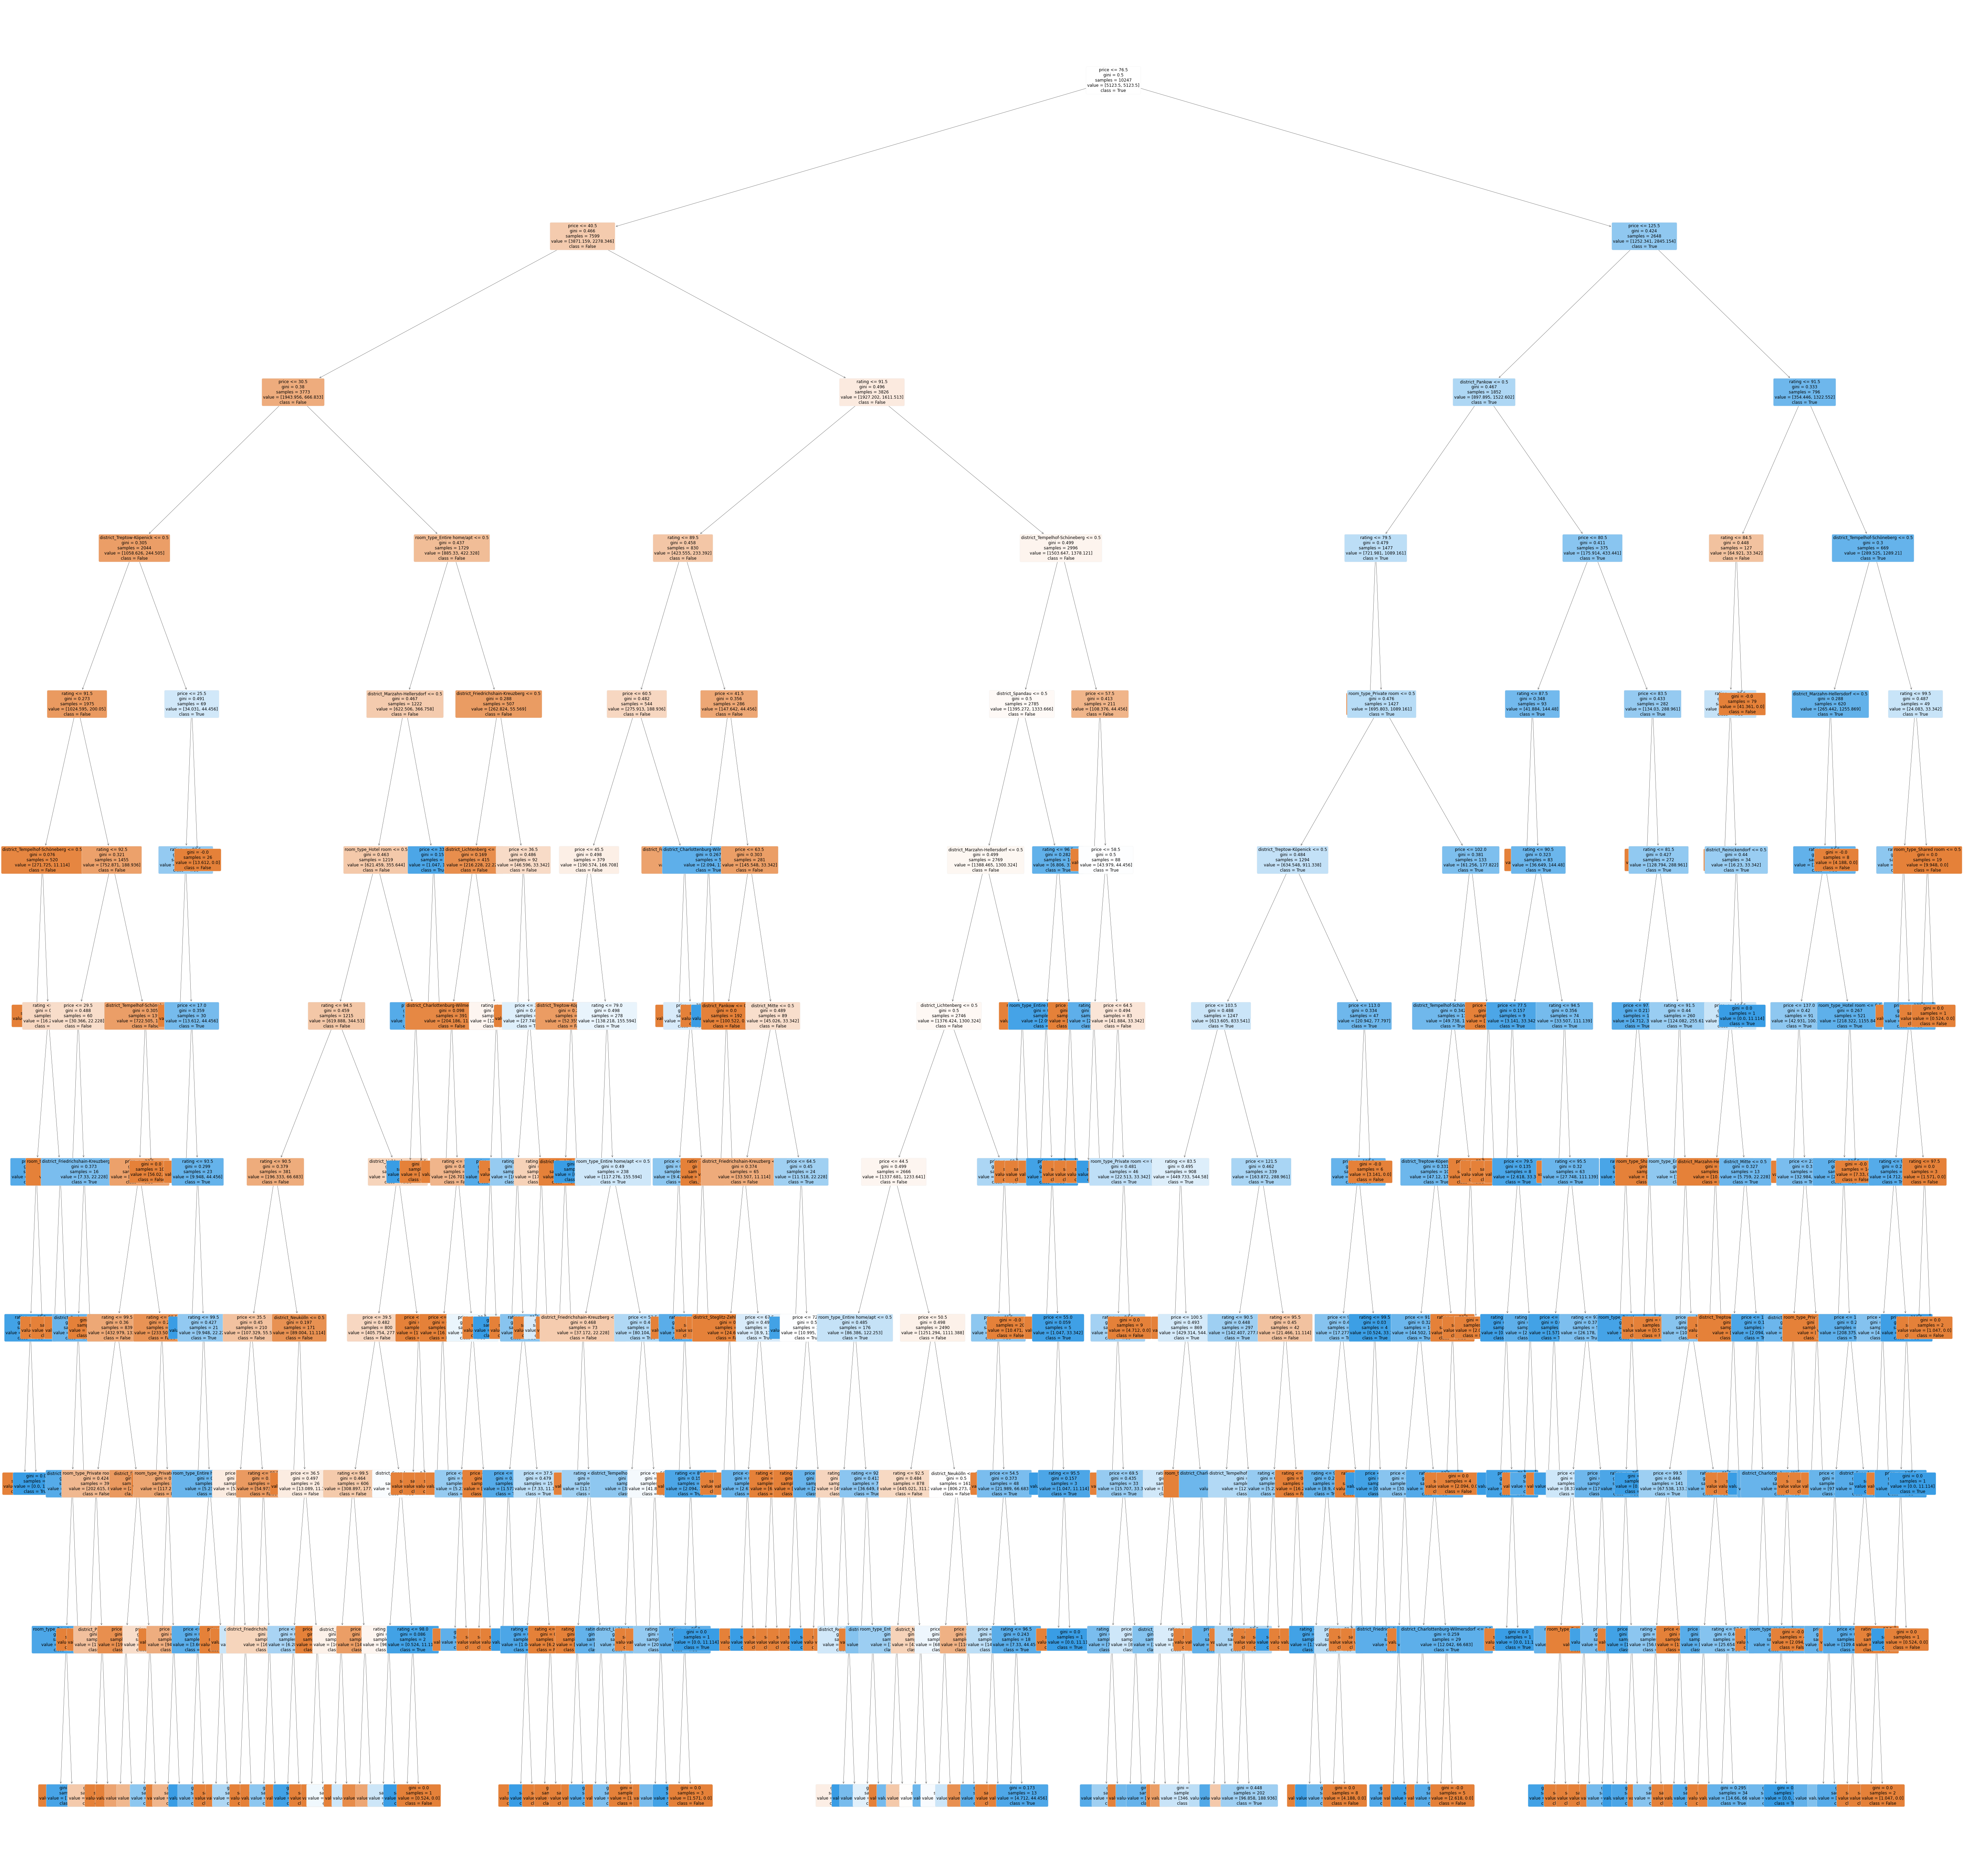

In [28]:
dt_model = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced', max_depth=11)
dt_model = dt_model.fit(df_X_train_enc, s_y_train_enc)

dt_model.get_depth()
dt_model.get_n_leaves()

# Feature Importances calculation
df_model_fi = pd.DataFrame(index=df_X_train_enc.columns)
df_model_fi['feature_importances_'] = dt_model.feature_importances_

# Better Permutation Feature Importances
df_model_fi['permutation_importances_train'] = permutation_importance(
    dt_model, df_X_train_enc, s_y_train_enc, n_repeats=30, random_state=1)['importances_mean']
df_model_fi['permutation_importances_train_norm'] = df_model_fi[
    'permutation_importances_train']/df_model_fi['permutation_importances_train'].sum()
df_model_fi.sort_values(by='feature_importances_', ascending=False)

# plot built tree
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(100,100))
#plot_tree(dt_model, ax=ax, fontsize=12, filled=True, rounded=True,
#          feature_names=df_X_train_enc.columns, class_names=labelenc.classes_.astype(str))
#plt.savefig('images/berlin_terraces_tree_balanced_depth11.png')


## 5. Evaluate model
### Confusion Matrix

              precision    recall  f1-score   support

       False       0.97      0.62      0.76      4813
        True       0.07      0.56      0.12       235

    accuracy                           0.62      5048
   macro avg       0.52      0.59      0.44      5048
weighted avg       0.93      0.62      0.73      5048



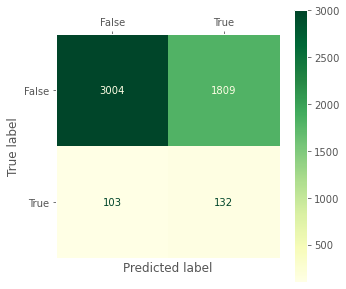

In [29]:
s_y_predicted = pd.Series(dt_model.predict(df_X_test_enc), name=y_label)
#accuracy_score(s_Y_test, s_Y_predicted)
#golf_tree.score(df_X_test, s_Y_test) #returns "score: Mean accuracy of self.predict(X) wrt. y."

#confusion_matrix(s_Y_test, s_Y_predicted) #normalize: {‘true’, ‘pred’, ‘all’}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.grid(False)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plot_confusion_matrix(dt_model, df_X_test_enc, s_y_test_enc,
                      display_labels=labelenc.classes_.astype(str), cmap='YlGn', ax=ax)

print(classification_report(s_y_test_enc, s_y_predicted, target_names=labelenc.classes_.astype(str)))

### Balance Class Weights!

**Observations:**
- "Aha!" moments:
    - balanced weight classes boosted terrace=True recall from 1% to 12% (some hope)
    - pruning down and then back up the max_depth to hit a peak True recall of 56% at depth of 12
    - this definitely needs a GridSearchCV to see how much higher we can get this up
        - ... but it could also go down with data cross-validation?